In [16]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19


In [17]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps


In [18]:
class Fusion:
    def __init__(self, input_images):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input_images
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuses self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for _ in self.input_images]
        self.YCbCr_images = [-1 for _ in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._transfer_to_tensor()
        # Perform fusion strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given RGB input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():
            imgs_sum_maps = [-1 for _ in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:, idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output

    def _RGB_to_YCbCr(self, img_RGB):
        """
        A private method which converts an RGB image to YCrCb format
        """
        img_RGB = img_RGB.astype(np.float32) / 255.
        return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
        """
        A private method which converts a YCrCb image to RGB format
        """
        img_YCbCr = img_YCbCr.astype(np.float32)
        return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
        """
        A private method which returns True if image is gray, otherwise False
        """
        if len(img.shape) < 3:
            return True
        if img.shape[2] == 1:
            return True
        b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
        if (b == g).all() and (b == r).all():
            return True
        return False

    def _softmax(self, tensor):
        """
        A private method which computes softmax output of a given tensor
        """
        tensor = torch.exp(tensor)
        tensor = tensor / tensor.sum(dim=1, keepdim=True)
        return tensor

    def _transfer_to_tensor(self):
        """
        A private method to transfer all input images to PyTorch tensors
        """
        self.images_to_tensors = []
        for image in self.normalized_images:
            np_input = image.astype(np.float32)
            if np_input.ndim == 2:
                np_input = np.repeat(np_input[None, None], 3, axis=1)
            else:
                np_input = np.transpose(np_input, (2, 0, 1))[None]
            if self.device == "cuda":
                self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
            else:
                self.images_to_tensors.append(torch.from_numpy(np_input))


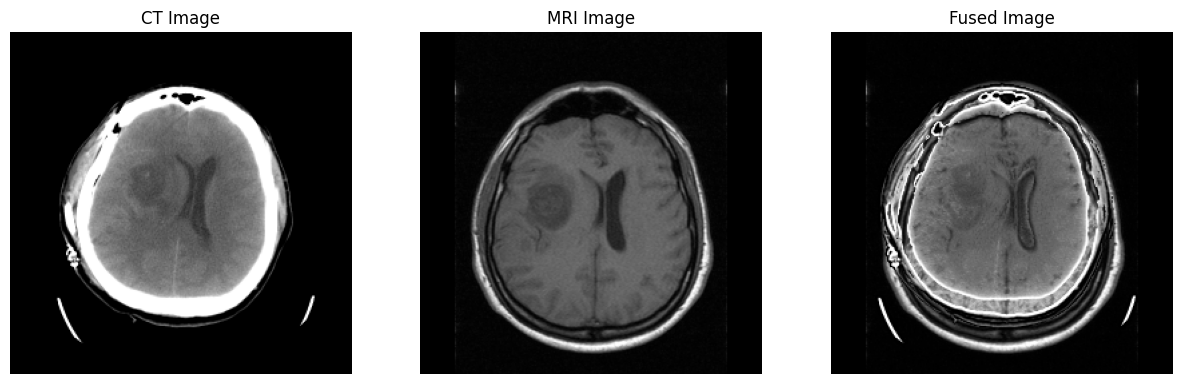

In [19]:
# Define a function to resize images
def resize_image(image, size=(256, 256)):
    return cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)

# Define paths to images
ct_image_path = 'D:/Image Fusion/dataset/Patient Data/p14/ct.jpg'
mri_image_path = 'D:/Image Fusion/dataset/Patient Data/p14/mri.jpg'
output_image_path = 'D:/Image Fusion/fused/2.jpg'

# Read and resize images
ct_image = cv2.imread(ct_image_path)
mri_image = cv2.imread(mri_image_path)
ct_image_resized = resize_image(ct_image, (256, 256))
mri_image_resized = resize_image(mri_image, (256, 256))

# Perform fusion
fusion_instance = Fusion([ct_image_resized, mri_image_resized])
fused_image = fusion_instance.fuse()

# Save fused image
cv2.imwrite(output_image_path, fused_image)

# Display the result (if running in a notebook environment)
import matplotlib.pyplot as plt

# Display images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(ct_image_resized, cv2.COLOR_BGR2RGB))
axes[0].set_title('CT Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(mri_image_resized, cv2.COLOR_BGR2RGB))
axes[1].set_title('MRI Image')
axes[1].axis('off')

axes[2].imshow(fused_image, cmap='gray')
axes[2].set_title('Fused Image')
axes[2].axis('off')

plt.show()
